In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from data_prep import Password as P
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

USE_CUDA = False
PRE_GEN_ITERS = 1000
ADVERSIVE_ITERS = 500
CRITIC_ITERS = 1

In [2]:
# custom weights initialization called on G and D
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 0.001)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, hidden_size):
        super(Discriminator, self).__init__()

        self.input_size = P.n_letters
        self.hidden_size = hidden_size
        self.output_size = 2
        
        self.i2h = nn.Sequential(*[
            nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        ])
        self.i2o = nn.Sequential(*[
            nn.Linear(self.input_size + self.hidden_size, self.output_size),
            nn.LogSoftmax(dim=1)
        ])
        
        self.i2h.apply(weights_init)
        self.i2o.apply(weights_init)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def requiresGrad(self):
        for p in self.parameters():
            p.requires_grad = True
            
    def requiresNoGrad(self):
        for p in self.parameters():
            p.requires_grad = False
    
    def train(self, input_tensor, target_tensor, criterion = nn.NLLLoss(), learning_rate = 0.005):
        hidden = self.initHidden()
        self.zero_grad()
        
        for i in range(input_tensor.size()[0]):
            output, hidden = self(input_tensor[i], hidden)
            
        loss = criterion(output, target_tensor)
        loss.backward()
        
        for p in self.parameters():
            p.data.add_(-learning_rate, p.grad.data)

        return output, loss.item()
    
    def discriminate(self, input_tensor):
        hidden = self.initHidden()
        for i in range(input_tensor.size()[0]):
            output, hidden = self(input_tensor[i], hidden)
        return output

In [4]:
class Generator(nn.Module):
    def __init__(self, hidden_size):
        super(Generator, self).__init__()
        
        self.input_size = P.n_letters
        self.hidden_size = hidden_size
        self.output_size = P.n_letters
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, self.output_size)
        self.dropout = nn.Dropout(0.1)
        self.hidden = self.initHiddenZeros()

    def forward(self, input):
        output, self.hidden = self.lstm(input.view(1,1,-1), self.hidden)
        output = self.h2o(output)
        output = self.dropout(output)
        output = F.log_softmax(output,dim=2)
        return output

    def initHiddenZeros(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))
    
    def initHiddenRand(self):
        return (torch.rand(1,1, self.hidden_size), 
                torch.rand(1,1, self.hidden_size))
    
    def generatePassTensor(self, max_length = 18):
        start_letter = p.passwords_string[random.randint(0,len(p.passwords_string) - 1)][0]
        with torch.no_grad():
            input_tensor = P.passwordToInputTensor(start_letter)
            self.hidden = self.initHiddenZeros()
            password = start_letter

            for c in range(max_length):
                output = self(input_tensor[0])
                output = output.view(1,-1)
                topv, topi = output.topk(1)
                topi = topi[0][0]
                if topi == P.n_letters - 1:
                    break
                else:
                    letter = P.all_letters[topi]
                    password += letter
                input_tensor = P.passwordToInputTensor(letter)
        
        return P.passwordToInputTensor(password)
        
    
    def generate_N(self, p, n_generate = 100, max_length = 18):
        generate_list = []

        for i in range(n_generate):
            start_letter = p.passwords_string[random.randint(0,len(p.passwords_string) - 1)][0]
            with torch.no_grad():
                input_tensor = P.passwordToInputTensor(start_letter)
                self.hidden = self.initHiddenZeros()
                output_password = start_letter

                for c in range(max_length):
                    output = self(input_tensor[0])
                    output = output.view(1,-1)
                    topv, topi = output.topk(1)
                    topi = topi[0][0]
                    if topi == P.n_letters - 1:
                        break
                    else:
                        letter = P.all_letters[topi]
                        output_password += letter
                    input_tensor = P.passwordToInputTensor(letter)
                    
            generate_list.append(output_password)
            
        return generate_list

    
    def pre_train(self, input_line_tensor, target_line_tensor):
        target_line_tensor.unsqueeze_(-1)
        self.hidden = self.initHiddenZeros()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=0.1)

        self.zero_grad()
        loss = torch.tensor(0, dtype = torch.float32, requires_grad = True)

        for i in range(input_line_tensor.size(0)):
            output = self(input_line_tensor[i])
            output = output.view(1,-1)
            l = criterion(output, target_line_tensor[i])
            loss = loss + l

        loss.backward()
        optimizer.step()

        return output, loss.item() / input_line_tensor.size(0)
    
    
    def train(self, D, p, criterion = nn.NLLLoss(), learning_rate = 0.005, max_length = 18):
        start_letter = p.passwords_string[random.randint(0,len(p.passwords_string) - 1)][0]
        input_tensor = P.passwordToInputTensor(start_letter)
        output_tensor = input_tensor
        self.hidden = self.initHiddenZeros()
       
        for c in range(max_length):
            output = self(input_tensor[0])
            output_tensor = torch.cat((output_tensor, torch.exp(output)), -3)
            
        output = D.discriminate(output_tensor)
        target_tensor = torch.tensor([1], dtype = torch.long)
        loss = criterion(output, target_tensor)
        loss.backward()
        
        for p in self.parameters():
            p.data.add_(-learning_rate, p.grad.data)

In [5]:
g = Generator(128)
d = Discriminator(128)
if USE_CUDA:
    g = g.cuda()
    d = d.cuda()

In [6]:
p = P()
passwords = p.passIter()

INFO:root:Initializing passwords...
DEBUG:root:Loading from existing json file...
INFO:root:Done initializing passwords.


In [7]:
print_every = 1000
loss_trend = []
logging.info("---------- Pre-training generator ----------")
for i in range(PRE_GEN_ITERS):
    pas = next(passwords)
    input_tensor = P.passwordToInputTensor(pas)
    target_tensor = P.passwordToTargetTensor(pas)
    output, loss = g.pre_train(input_tensor, target_tensor)
    
    if i % print_every == 0:
        logging.debug("Iter: "+ str(i)+" Loss: "+str(loss))
        loss_trend.append(loss)

INFO:root:---------- Pre-training generator ----------
DEBUG:root:Iter: 0 Loss: 4.349316279093425


In [20]:
logger.setLevel(logging.DEBUG)
logging.info("---------- Adversarial Training ----------\n")

for i in range(1, ADVERSIVE_ITERS + 1):
    logging.debug("----------------- %d / %d -----------------" % (i, ADVERSIVE_ITERS))
    logging.debug("Training discriminator...")
    
    d.requiresGrad()
    g.zero_grad()
    
    correct = 0
    for j in range(CRITIC_ITERS):
        password_tensor = g.generatePassTensor()
        category_tensor = torch.tensor([0], dtype = torch.long)
        output, loss = d.train(password_tensor, category_tensor)
        if output[0][0] > output[0][1]:
            correct += 1
        password_tensor = P.passwordToInputTensor(next(passwords))
        category_tensor = torch.tensor([1], dtype = torch.long)
        output, loss = d.train(password_tensor, category_tensor)
        if output[0][0] < output[0][1]:
            correct += 1
        
    logging.debug("Done. Classification accuracy: " + str(correct / CRITIC_ITERS / 2))    
    
    logging.debug("Training generator...")
    
    d.requiresNoGrad()
    
    g.train(d, p)
    
    logging.debug("Done training generator.\n")
    

INFO:root:---------- Adversarial Training ----------

DEBUG:root:----------------- 1 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 2 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 0.5
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 3 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 4 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 5 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Class

DEBUG:root:----------------- 40 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 0.5
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 41 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 42 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 43 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 44 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training gener

DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 80 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 81 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 0.5
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 82 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 83 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:

DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 119 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 120 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 0.5
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 121 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 122 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 0.5
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 123 / 500 -----

DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 158 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 159 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 160 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 161 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 162 / 500 -----------------
DEBUG:root:Training discriminator

DEBUG:root:Done training generator.

DEBUG:root:----------------- 197 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 198 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 199 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 200 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 201 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classificati

DEBUG:root:----------------- 236 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 237 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 238 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 0.5
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 239 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 240 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training 

DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 276 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 277 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 278 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 279 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:r

DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 315 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 316 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 317 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 318 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 319 / 500 -----

DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 354 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 355 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 356 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 357 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 358 / 500 -----------------
DEBUG:root:Training discriminator

DEBUG:root:Done training generator.

DEBUG:root:----------------- 393 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 394 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 395 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 396 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 397 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classificati

DEBUG:root:----------------- 432 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 433 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 434 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 0.5
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 435 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 436 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training 

DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 472 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 473 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 474 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:root:----------------- 475 / 500 -----------------
DEBUG:root:Training discriminator...
DEBUG:root:Done. Classification accuracy: 1.0
DEBUG:root:Training generator...
DEBUG:root:Done training generator.

DEBUG:r

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


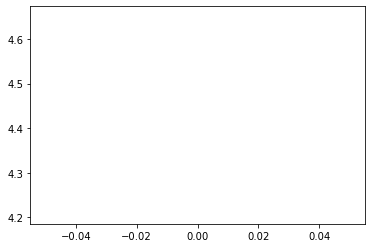

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

logger.setLevel(logging.INFO)

plt.figure()
plt.plot(loss_trend)
#plt.savefig('pictures/rnn-rnn-loss.png',dpi=400)
plt.show()

In [11]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)

In [21]:
print(g.generate_N(p))

['canian', 'manana', 'lanana', 'kanana', '0aniana', 'panana', 'bariana', '3anana', '1anana', 'manarer', '0anana', 'Tilana', '3anana', 'taniana', 'onana', '4anana', '4alina', 'hanana', 'manana', 'ponana', 'tanianan', '0anana', 'fanana', 'banana', 'ianane', 'panana', '1onana', 'nanana', '2aniana', 'ananana', 'bariana', '4anana', 'lanara', 'barian', 'Sanana', 'monanan', 'banana', '6ariana', 'ranama', '0anana', 'Banana', 'yanana', 'caniana', 'caniana', 'anarana', 'cinane', 'zanana', '1anane', 'coniana', 'lariana', 'fanian', 'taniana', '6aniana', 'janiana', 'zanamar', 'nanana', '5anana', '5anana', 'saniana', 'manana', '8aniana', '8anana', '9anana', 'Xanana', '3anana', 'canian', 'canianan', 'Sanara', '1oranda', 'sanana', 'janana', 'ranane', 'uanana', 'taniana', 'banana', 'manana', 'jariana', 'manana', '2arina', 'erina', 'caninana', 'Ganana', 'beria', '0anana', 'ranana', '8aniana', 'mariana', 'panana', 'daria', 'vanara', 'Ponana', 'tonana', '8ania', 'ananana', 'raniana', 'yanana', '0ariana', 

In [13]:
torch.cat((torch.zeros(4,1,2), torch.zeros(1,1,2)), -3)

tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])

In [14]:
torch.zeros(2,1,2)

tensor([[[0., 0.]],

        [[0., 0.]]])

In [15]:
torch.exp(torch.zeros(1,2))

tensor([[1., 1.]])

In [4]:
torch.FloatTensor([1])*-1

tensor([-1.])

In [21]:
a = torch.FloatTensor([1])
a.requires_grad = True
b = a * 2
b.backward(torch.FloatTensor([-1]))

In [22]:
print(a.grad)

tensor([-2.])
